# Linear Elasticity in 2D for 3 Phases

## Introduction

This example provides a demonstration of using PyMKS to compute the linear strain field for a three-phase composite material. It demonstrates how to generate data for delta microstructures and then use this data to calibrate the first order MKS influence coefficients. The calibrated influence coefficients are used to predict the strain response for a random microstructure and the results are compared with those from finite element. Finally, the influence coefficients are scaled up and the MKS results are again compared with the finite element data for a large problem.

PyMKS uses the finite element tool [SfePy](http://sfepy.org) to generate both the strain fields to fit the MKS model and the verification data to evaluate the MKS model's accuracy.

### Elastostatics Equations and Boundary Conditions

The governing equations for linear elasticity and the boundary conditions used in this example are the same as those provided in the [Linear Elastic in 2D](elasticity_2D.html) example. 

## Modeling with MKS

### Calibration Data and Delta Microstructures

The first order MKS influence coefficients are all that is needed to compute a strain field of a random microstructure as long as the ratio between the elastic moduli (also known as the contrast) is less than 1.5. If this condition is met we can expect a mean absolute error of 2%  or less when comparing the MKS results with those computed using finite element methods [[1]](#ref1). 

Because we are using distinct phases and the contrast is low enough to only need the first-order coefficients, delta microstructures and their strain fields are all that we need to calibrate the first-order influence coefficients [[2]](#ref2). 

Here we use the `make_delta_microstructure` function from `pymks.datasets` to create the delta microstructures needed to calibrate the first-order influence coefficients for a two-phase microstructure. The `make_delta_microstructure` function uses SfePy to generate the data.

In [15]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

import pymks

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

from pymks.tools import draw_microstructures
from pymks.datasets import make_delta_microstructures


n = 21
n_phases = 3
X_delta = make_delta_microstructures(n_phases=n_phases, size=(n, n))


Let's take a look at a few of the delta microstructures by importing `draw_microstructures` from `pymks.tools`.

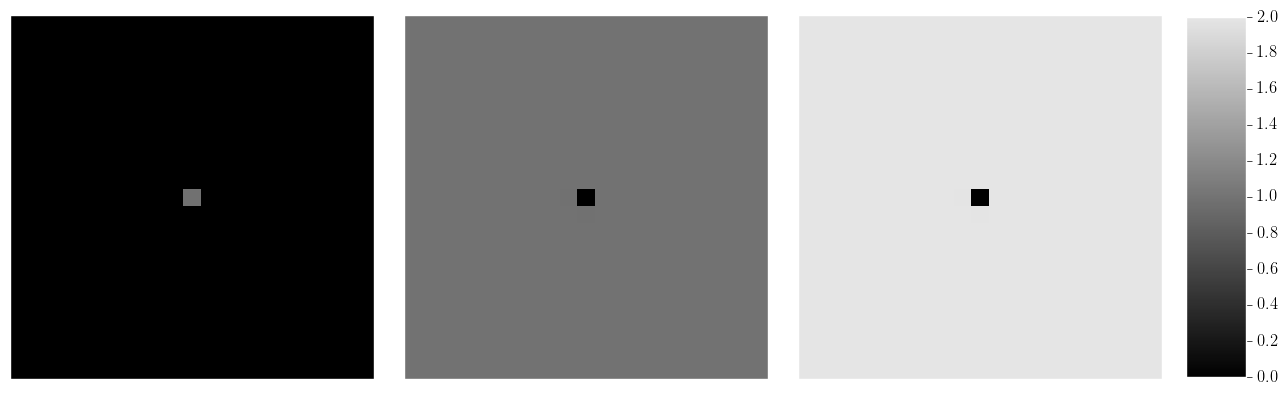

In [17]:
draw_microstructures(X_delta[::2])


Using delta microstructures for the calibration of the first-order influence coefficients is essentially the same, as using a unit [impulse response](http://en.wikipedia.org/wiki/Impulse_response) to find the kernel of a system in signal processing. Any given delta microstructure is composed of only two phases with the center cell having an alternative phase from the remainder of the domain. The number of delta microstructures that are needed to calibrated the first-order coefficients is $N(N-1)$ where $N$ is the number of phases, therefore in this example we need 6 delta microstructures.

### Generating Calibration Data

The `make_elasticFEstrain_delta` function from `pymks.datasets` provides an easy interface to generate delta microstructures and their strain fields, which can then be used for calibration of the influence coefficients. The function calls the `ElasticFESimulation` class to compute the strain fields.

In this example, lets look at a three phase microstructure with elastic moduli values of 80, 100 and 120 and Poisson's ratio values all equal to 0.3. Let's also set the macroscopic imposed strain equal to 0.02. All of these parameters used in the simulation must be passed into the `make_elasticFEstrain_delta` function. The number of Poisson's ratio values and elastic moduli values indicates the number of phases. Note that `make_elasticFEstrain_delta` does not take a number of samples argument as the number of samples to calibrate the MKS is fixed by the number of phases.

In [18]:
from pymks.datasets import make_elastic_FE_strain_delta
from pymks.tools import draw_microstructure_strain


elastic_modulus = (80, 100, 120)
poissons_ratio = (0.3, 0.3, 0.3)
macro_strain = 0.02
size = (n, n)

X_delta, strains_delta = make_elastic_FE_strain_delta(elastic_modulus=elastic_modulus,
                                                      poissons_ratio=poissons_ratio,
                                                      size=size, macro_strain=macro_strain)


Let's take a look at one of the delta microstructures and the $\varepsilon_{xx}$ strain field.

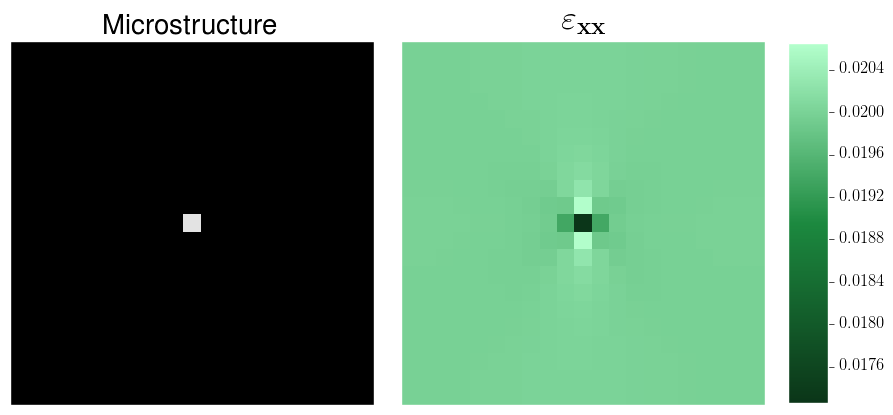

In [19]:
draw_microstructure_strain(X_delta[0], strains_delta[0])


Because `slice(None)` (the default slice operator in Python, equivalent to array[:]) was passed in to the `make_elasticFEstrain_delta` function as the argument for `strain_index`, the function returns all the strain fields. Let's also take a look at the $\varepsilon_{yy}$ and $\varepsilon_{xy}$ strain fields.

### Calibrating First-Order Influence Coefficients

Now that we have the delta microstructures and their strain fields, we will calibrate the influence coefficients by creating an instance of the `MKSLocalizatoinModel` class. Because we are going to calibrate the influence coefficients with delta microstructures, we can create an instance of `PrimitiveBasis` with `n_states` equal to 3, and use it to create an instance of `MKSLocalizationModel`. The delta microstructures and their strain fields will then be passed to the `fit` method. 

In [20]:
from pymks import MKSLocalizationModel
from pymks import PrimitiveBasis


p_basis =PrimitiveBasis(n_states=3, domain=[0, 2])
model = MKSLocalizationModel(basis=p_basis)


Now, pass the delta microstructures and their strain fields into the `fit` method to calibrate the first-order influence coefficients.

In [21]:
model.fit(X_delta, strains_delta)


That's it, the influence coefficient have been calibrated. Let's take a look at them.

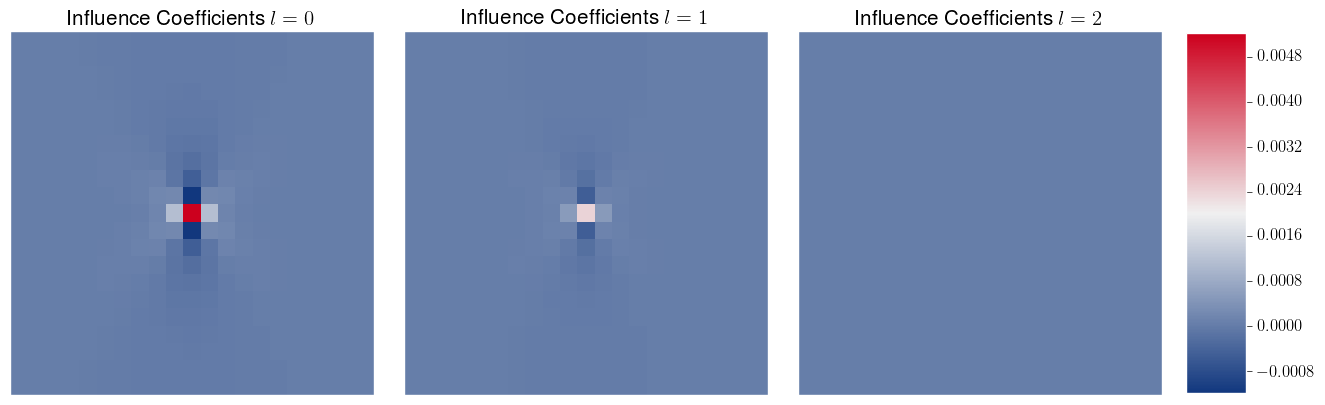

In [22]:
from pymks.tools import draw_coeff


draw_coeff(model.coef_)


The influence coefficients for $l=0$ and $l = 1$ have a Gaussian-like shape, while the influence coefficients for $l=2$ are constant-valued. The constant-valued influence coefficients may seem superfluous, but are equally as important. They are equivalent to the constant term in multiple linear regression with [categorical variables](http://en.wikipedia.org/wiki/Dummy_variable_%28statistics%29).

### Predict of the Strain Field for a Random Microstructure

Let's now use our instance of the `MKSLocalizationModel` class with calibrated influence coefficients to compute the strain field for a random two-phase microstructure and compare it with the results from a finite element simulation. 

The `make_elasticFEstrain_random` function from `pymks.datasets` is an easy way to generate a random microstructure and its strain field results from finite element analysis.  

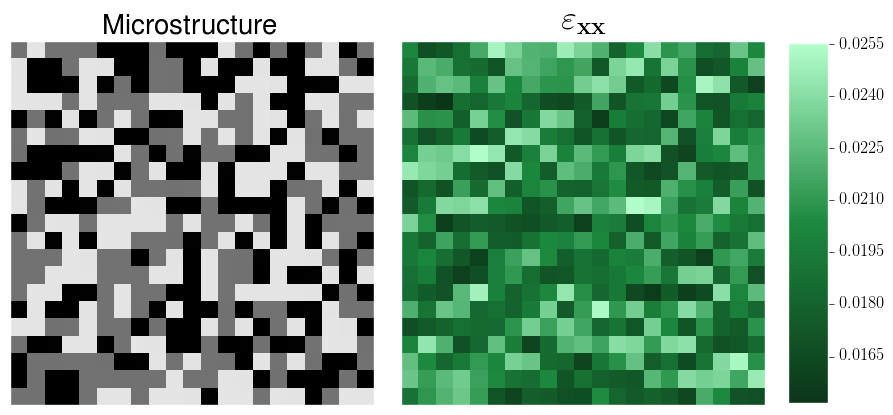

In [23]:
from pymks.datasets import make_elastic_FE_strain_random


np.random.seed(101)
X, strain = make_elastic_FE_strain_random(n_samples=1, elastic_modulus=elastic_modulus,
                                          poissons_ratio=poissons_ratio, size=size, 
                                          macro_strain=macro_strain)
draw_microstructure_strain(X[0] , strain[0])


**Note that the calibrated influence coefficients can only be used to reproduce the simulation with the same boundary conditions that they were calibrated with.**

Now, to get the strain field from the `MKSLocalizationModel`, just pass the same microstructure to the `predict` method.

In [24]:
strain_pred = model.predict(X)


Finally let's compare the results from finite element simulation and the MKS model.

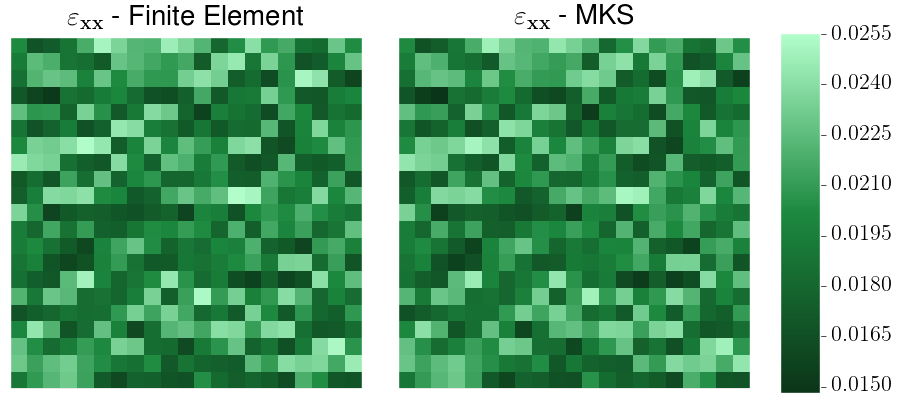

In [25]:
from pymks.tools import draw_strains_compare


draw_strains_compare(strain[0], strain_pred[0])


Let's plot the difference between the two strain fields.

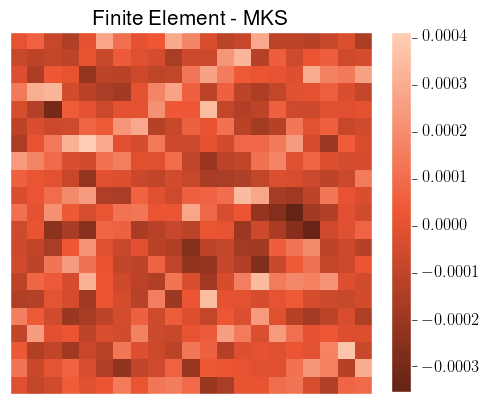

In [26]:
from pymks.tools import draw_differences


draw_differences([strain[0] - strain_pred[0]], ['Finite Element - MKS'])


The MKS model is able to capture the strain field for the random microstructure after being calibrated with delta microstructures.

## Resizing the Coefficeints to use on Larger Microstructures 

The influence coefficients that were calibrated on a smaller microstructure can be used to predict the strain field on a larger microstructure though spectral interpolation [[3]](#ref3), but accuracy of the MKS model drops slightly. To demonstrate how this is done, let's generate a new larger random microstructure and its strain field.

(63, 63)


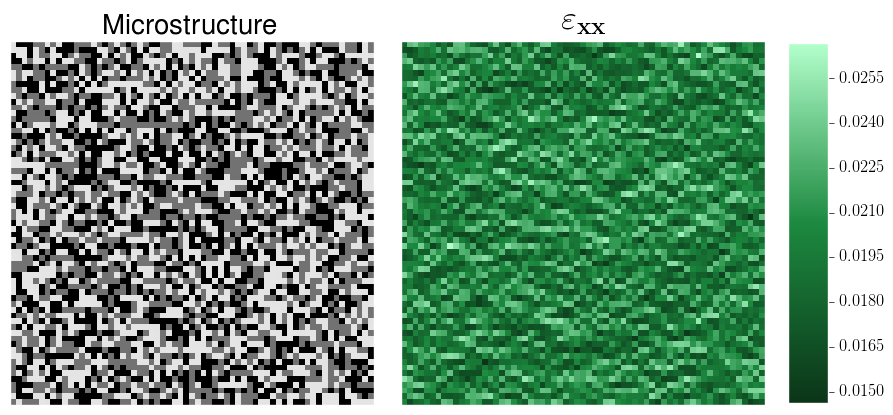

In [27]:
m = 3 * n 
size = (m, m)
print(size)
X, strain = make_elastic_FE_strain_random(n_samples=1, elastic_modulus=elastic_modulus,
                                          poissons_ratio=poissons_ratio, size=size, 
                                          macro_strain=macro_strain)
draw_microstructure_strain(X[0] , strain[0])


The influence coefficients that have already been calibrated on a $n$ by $n$ delta microstructures, need to be resized to match the shape of the new larger $m$ by $m$ microstructure that we want to compute the strain field for. This can be done by passing the shape of the new larger microstructure into the `resize_coeff` method.

In [28]:
model.resize_coeff(X[0].shape)


Let's now take a look that ther resized influence coefficients.

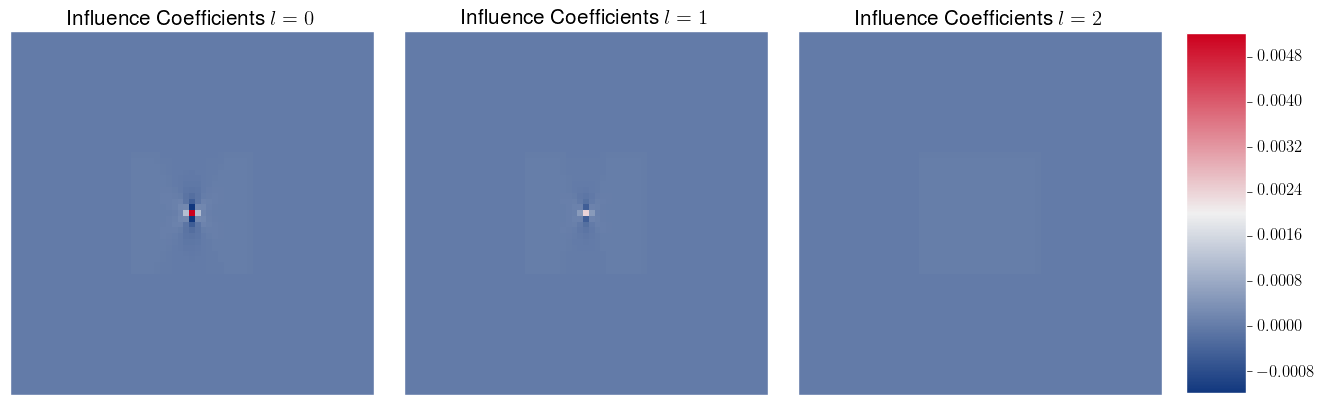

In [29]:
draw_coeff(model.coef_)


Because the coefficients have been resized, they will no longer work for our original $n$ by $n$ sized microstructures they were calibrated on, but they can now be used on the $m$ by $m$ microstructures. Just like before, just pass the microstructure as the argument of the `predict` method to get the strain field.

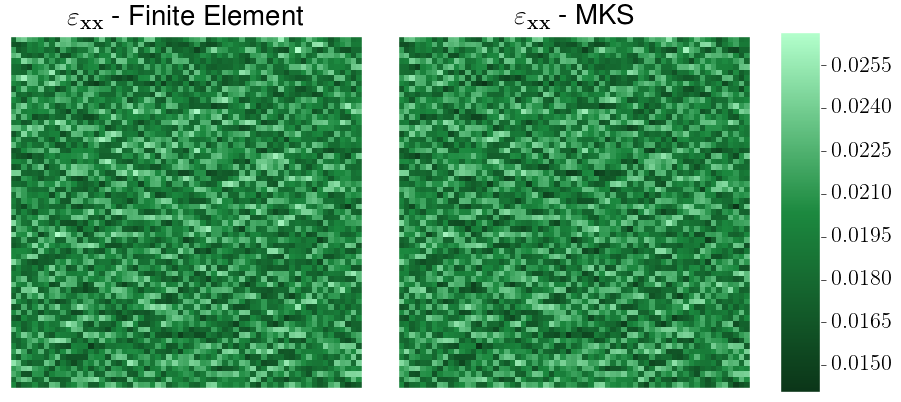

In [30]:
strain_pred = model.predict(X)

draw_strains_compare(strain[0], strain_pred[0])


Again, let's plot the difference between the two strain fields.

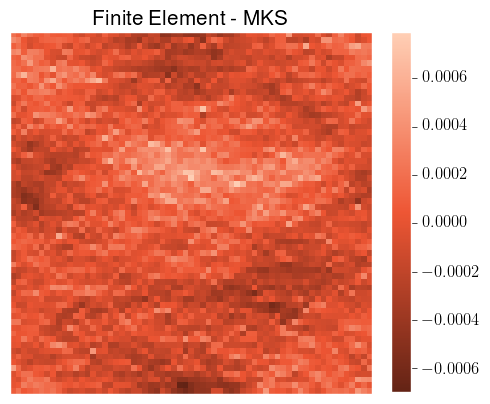

In [31]:
draw_differences([strain[0] - strain_pred[0]], ['Finite Element - MKS'])


As you can see, the results from the strain field computed with the resized influence coefficients is not as accurate as they were before they were resized. This decrease in accuracy is expected when using spectral interpolation [[4]](#ref4).


## References

<a id="ref1"></a>
[1] Binci M., Fullwood D., Kalidindi S.R., A new spectral framework for establishing localization relationships for elastic behavior of composites and their calibration to finite-element models. Acta Materialia, 2008. 56 (10) p. 2272-2282 [doi:10.1016/j.actamat.2008.01.017](http://dx.doi.org/10.1016/j.actamat.2008.01.017).

<a id="ref2"></a>
[2] Landi, G., S.R. Niezgoda, S.R. Kalidindi, Multi-scale modeling of elastic response of three-dimensional voxel-based microstructure datasets using novel DFT-based knowledge systems. Acta Materialia, 2009. 58 (7): p. 2716-2725 [doi:10.1016/j.actamat.2010.01.007](http://dx.doi.org/10.1016/j.actamat.2010.01.007).

<a id="ref3"></a>
[3] Marko, K., Kalidindi S.R., Fullwood D., Computationally efficient database and spectral interpolation for fully plastic Taylor-type crystal plasticity calculations of face-centered cubic polycrystals. International Journal of Plasticity 24 (2008) 1264–1276 [doi:10.1016/j.ijplas.2007.12.002](http://dx.doi.org/10.1016/j.ijplas.2007.12.002).

<a id="ref4"></a>
[4] Marko, K. Al-Harbi H. F. , Kalidindi S.R., Crystal plasticity simulations using discrete Fourier transforms. Acta Materialia 57 (2009) 1777–1784 [doi:10.1016/j.actamat.2008.12.017](http://dx.doi.org/10.1016/j.actamat.2008.12.017).